# Exercise 06
# TensorFlow and Keras


---

In [36]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

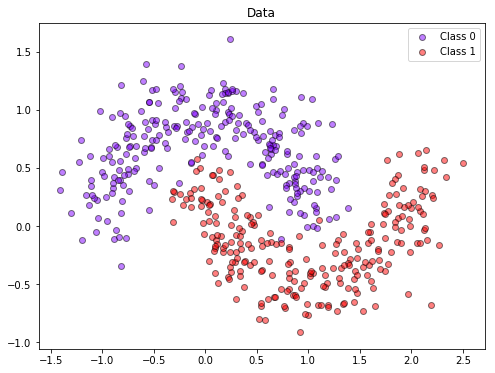

In [37]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [38]:
import tensorflow as tf
numN = 10
graph = tf.Graph()
with graph.as_default():
    
    #DATOS ENTRADA:
    x = tf.placeholder(tf.float32,shape=[None,2]) #Los datos de entrenamiento son parejas. None representa el total de filas y es None pq en este punto no se sabe el tamaño
    y_true = tf.placeholder(tf.float32,shape=None)
           
    with tf.name_scope('hidden_layer') as scope: 
        w1 = tf.Variable(tf.random_normal([numN,2]),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal([numN,1]),dtype=tf.float32,name='bias_1') 
   
        #h = tf.matmul(w_1,tf.transpose(x)) + b1
        h = tf.sigmoid(tf.matmul(w1,tf.transpose(x)) + b1, name='sigmoid') #brosfcasting
   
    
    #MODELO INFERENCIA 
    with tf.name_scope('inference') as scope:
        w = tf.Variable(tf.random_normal([1,numN]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.sigmoid(tf.matmul(w,h) + b )
    
    
    #FUNCION DE PERDIDA (SIGMOIDE)    
    with tf.name_scope('loss') as scope: #calculo de la perdida
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred) #el sigmoide esta implicito en la funcion de perdida
        loss = tf.reduce_mean(loss) #mean es el promedio de la funcion de perdida
  
   
    #FUNCION ENTRENAMIENTO
    with tf.name_scope('train') as scope: #proceso de entrenamiento
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss) #minimiza la funcion de perdida

    init = tf.global_variables_initializer() #inicializacion de variables. hay que hacerlo siempre

show_graph(graph.as_graph_def()) #visualization of the CG of the model.

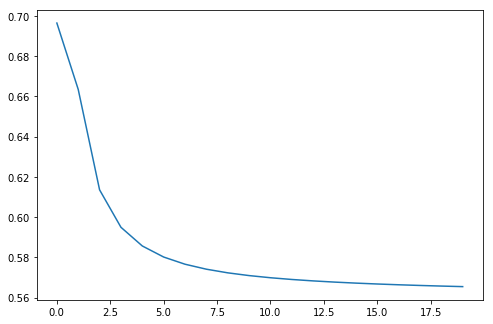

In [39]:
#num_epochs = 500
#losses = []

#with graph.as_default():
    #sess = tf.Session()
    #sess.run(init)      
    #for step in range(num_epochs):
        #sess.run(train,{x: X, y_true: Y})
        #if (step % 50 == 0):
            #losses.append(sess.run(loss, {x: X, y_true: Y}))
                       
#pl.figure(figsize = (8,16/3))
#pl.plot(losses)


num_epochs = 1000
losses = []

with graph.as_default(): 
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train}) 
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train})) 
                       
pl.figure(figsize = (8,16/3)) 
pl.plot(losses) snapshot from TensorBoard that shows the evolution of the training and test loss.

[[-0.800447    1.504145  ]
 [-1.1243105   3.1553483 ]
 [-0.42809558 -0.13005285]
 [-0.6060563   0.7315314 ]
 [ 1.0599233   1.3459423 ]
 [-0.65360785  2.057188  ]
 [ 1.1691993   2.4016995 ]
 [ 0.86923134 -3.8415723 ]
 [-1.085275   -1.3017278 ]
 [-0.934176    2.6738217 ]]
[[0.0002483]]


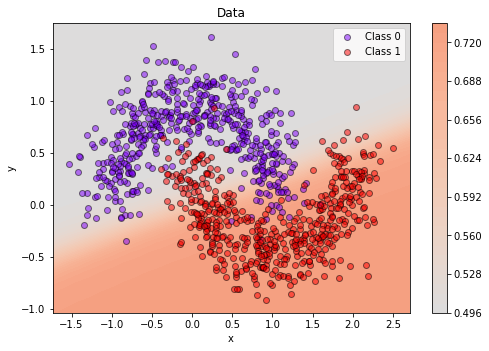

In [40]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])}) 
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)  #visualization of the decision region along with the test data.
plot_data(X, Y)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


In [ ]:
#usar el código de la ultima parte de la clase 11. Documentar. Que se usó y cuales mejoraron. 
#usar relu, celu, tangente hiperbolica

In [77]:
# Desarrollo del ejercicio
# Se presenta a continuación el Text Classifier Trained del notebook 11

from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')



print(x_train[101])



word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])


tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


import keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


#build a dense neural network with one hidden layer
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


#configure the learning task to use SGD as optimization:
from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


#train the model using a 0.1 training validation split:
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


#test the performance over the test set:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Loading data...
8982 train sequences
2246 test sequences
46 classes
[1, 2, 149, 8, 25, 2, 400, 304, 200, 6, 337, 4, 342, 2, 2, 7, 2, 2, 9, 4, 342, 643, 2, 7, 2, 4, 88, 2, 31, 4, 384, 292, 211, 5, 2, 978, 220, 33, 851, 2, 11, 15, 9, 447, 7, 42, 92, 131, 276, 5, 156, 11, 15, 50, 33, 30, 2, 7, 2, 383, 29, 336, 25, 383, 29, 2, 94, 156, 4, 49, 8, 7, 788, 4, 88, 33, 2, 747, 11, 15, 197, 92, 222, 825, 5, 934, 11, 15, 2, 8, 17, 12]
['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'expor

In [78]:
# Probamos el Text Classifier con diferentes funciones de activación para la capa oculta de la red:

In [79]:
#Activación Softmax
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('softmax'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_23 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_23 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_24 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_24 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 168us/step - loss: 3.6315 - acc: 0.3475 - val_loss: 3.4569 - val_acc: 0.3315
Epoch 2/5
8083/8083 [===============

In [80]:
#Activación Elu
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('elu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_25 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_25 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_26 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_26 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 148us/step - loss: 2.2565 - acc: 0.4924 - val_loss: 1.8610 - val_acc: 0.5551
Epoch 2/5
8083/8083 [===============

In [81]:
#Activación Selu
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('selu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_27 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_27 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_28 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_28 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 150us/step - loss: 2.0383 - acc: 0.5135 - val_loss: 1.7053 - val_acc: 0.5951
Epoch 2/5
8083/8083 [===============

In [82]:
#Activación SoftPlus
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('softplus'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_29 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_29 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_30 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_30 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 153us/step - loss: 2.2435 - acc: 0.4269 - val_loss: 2.0838 - val_acc: 0.4538
Epoch 2/5
8083/8083 [===============

In [83]:
#Activación SoftSign
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('softsign'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_31 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_31 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_32 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_32 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 148us/step - loss: 2.4392 - acc: 0.4774 - val_loss: 2.0023 - val_acc: 0.5061
Epoch 2/5
8083/8083 [===============

In [84]:
#Activación Relu
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_33 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_33 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_34 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_34 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 149us/step - loss: 2.5045 - acc: 0.4482 - val_loss: 1.9989 - val_acc: 0.5061
Epoch 2/5
8083/8083 [===============

In [85]:
#Activación Tanh
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('tanh'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_35 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_35 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_36 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_36 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 156us/step - loss: 2.2454 - acc: 0.4821 - val_loss: 1.8191 - val_acc: 0.5462
Epoch 2/5
8083/8083 [===============

In [ ]:
#Activación Sigmoid se aplicó en el ejercicio inicial

In [86]:
#Activación Hard_Sigmoid
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('hard_sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_37 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_37 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_38 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_38 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 170us/step - loss: 2.4607 - acc: 0.3582 - val_loss: 2.3594 - val_acc: 0.3393
Epoch 2/5
8083/8083 [===============

In [87]:
#Activación Linear
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('linear'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_39 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_39 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_40 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_40 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 155us/step - loss: 2.1301 - acc: 0.5043 - val_loss: 1.8024 - val_acc: 0.5729
Epoch 2/5
8083/8083 [===============

In [89]:
print ('La mejor Función de Activación para la capa oculta resultó ser Selu con un Test Accuracy de 0.7159 y el peor resultó ser Softmax con un Test Accuracy de 0.3619')

La mejor Función de Activación para la capa oculta resultó ser Selu con un Test Accuracy de 0.7159 y el peor resultó ser Softmax con un Test Accuracy de 0.3619


In [ ]:
# Probamos el Text Classifier con diferentes Optimizadores:

In [ ]:
#Optimizador SGD se aplicó en el ejercicio inicial

In [97]:
#Optimizador RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_53 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_53 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_54 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_54 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 232us/step - loss: 1.5287 - acc: 0.6536 - val_loss: 1.2795 - val_acc: 0.7208
Epoch 2/5
8083/8083 [===============

In [98]:
#Optimizador Adagrad
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import Adagrad

model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_55 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_55 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_56 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_56 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 205us/step - loss: 1.3828 - acc: 0.6863 - val_loss: 1.2406 - val_acc: 0.7264
Epoch 2/5
8083/8083 [===============

In [99]:
#Optimizador Adadelta
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import Adadelta

model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_57 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_57 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_58 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_58 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 258us/step - loss: 1.7126 - acc: 0.6005 - val_loss: 1.4271 - val_acc: 0.6986
Epoch 2/5
8083/8083 [===============

In [100]:
#Optimizador Adam
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_59 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_59 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_60 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_60 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 253us/step - loss: 1.6242 - acc: 0.6275 - val_loss: 1.2908 - val_acc: 0.7208
Epoch 2/5
8083/8083 [===============

In [101]:
#Optimizador Adamax
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import Adamax

model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_61 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_61 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_62 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_62 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 215us/step - loss: 1.6625 - acc: 0.6178 - val_loss: 1.4073 - val_acc: 0.6897
Epoch 2/5
8083/8083 [===============

In [102]:
#Optimizador Nadam
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import Nadam

model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_63 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_63 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_64 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_64 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 255us/step - loss: 1.3910 - acc: 0.6856 - val_loss: 1.1101 - val_acc: 0.7475
Epoch 2/5
8083/8083 [===============

In [105]:
#Optimizador TFOptimizer
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import TFOptimizer

model.compile(loss='categorical_crossentropy',
              optimizer=TFOptimizer(optimizer),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_69 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_69 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_70 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_70 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 180us/step - loss: 12.5824 - acc: 0.2160 - val_loss: 12.5502 - val_acc: 0.2214
Epoch 2/5
8083/8083 [=============

In [106]:
print ('El mejor Optimizador es Adam, pues resulta un Test Accuracy de 0.7969. El peor es TFOptimizer, con un Test Accuracy de 0.2110')

El mejor Optimizador es Adam, pues resulta un Test Accuracy de 0.7969. El peor es TFOptimizer, con un Test Accuracy de 0.2110


In [ ]:
# Probamos el Text Classifier con diferentes omisiones entre la capa oculta y la capa de salida:

In [ ]:
#omisiones entre la capa oculta y la capa de salida: Dense y Activation se aplicaron en el ejercicio inicial

In [130]:
#omisiones entre la capa oculta y la capa de salida: Dropout
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_92 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_93 (Activation)     (None, 256)                 0          
______________________________________________________________________
dropout_8 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_93 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_94 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [========

In [131]:
print('El dropout entre la capa oculta y la capa de salida que arroja un mejor test Accuracy (0.5142) es de 0.5')

El dropout entre la capa oculta y la capa de salida que arroja un mejor test Accuracy (0.5142) es de 0.5


In [ ]:
# Probamos el Text Classifier con diferentes Inicializadores para las capas densas:

In [160]:
#Inicializador RandomNormal
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='random_normal', bias_initializer='Zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_145 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_141 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_146 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_142 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 282us/step - loss: 2.4153 - acc: 0.3667 - val_loss: 2.2864 - val_acc: 0.4194
Epoch 2/5
8083/8083 [===============

In [161]:
#Inicializador RandomUniform
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='random_uniform', bias_initializer='Zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_147 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_143 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_148 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_144 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 285us/step - loss: 2.4464 - acc: 0.3604 - val_loss: 2.3150 - val_acc: 0.3793
Epoch 2/5
8083/8083 [===============

In [162]:
#Inicializador TruncatedNormal
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='truncated_normal', bias_initializer='Zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_149 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_145 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_150 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_146 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 308us/step - loss: 2.4599 - acc: 0.3580 - val_loss: 2.3018 - val_acc: 0.4427
Epoch 2/5
8083/8083 [===============

In [163]:
#Inicializador VarianceScaling
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='VarianceScaling', bias_initializer='Zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_151 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_147 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_152 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_148 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 298us/step - loss: 2.4239 - acc: 0.3582 - val_loss: 2.3089 - val_acc: 0.4138
Epoch 2/5
8083/8083 [===============

In [164]:
#Inicializador Orthogonal
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='Orthogonal', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_153 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_149 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_154 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_150 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 3s 319us/step - loss: 2.4159 - acc: 0.3637 - val_loss: 2.3297 - val_acc: 0.3682
Epoch 2/5
8083/8083 [===============

In [165]:
#Inicializador Lecun_uniform
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='lecun_uniform', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_155 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_151 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_156 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_152 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 303us/step - loss: 2.4367 - acc: 0.3640 - val_loss: 2.3200 - val_acc: 0.3815
Epoch 2/5
8083/8083 [===============

In [166]:
#Inicializador glorot_nornal
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='glorot_normal', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_157 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_153 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_158 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_154 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 304us/step - loss: 2.4403 - acc: 0.3622 - val_loss: 2.3198 - val_acc: 0.3560
Epoch 2/5
8083/8083 [===============

In [167]:
#Inicializador glorot_uniform
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_159 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_155 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_160 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_156 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 309us/step - loss: 2.4213 - acc: 0.3668 - val_loss: 2.3097 - val_acc: 0.3704
Epoch 2/5
8083/8083 [===============

In [168]:
#Inicializador he_normal
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_161 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_157 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_162 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_158 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 300us/step - loss: 2.4196 - acc: 0.3705 - val_loss: 2.2988 - val_acc: 0.3927
Epoch 2/5
8083/8083 [===============

In [169]:
#Inicializador lecun_normal
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='lecun_normal', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_163 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_159 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_164 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_160 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 3s 310us/step - loss: 2.4269 - acc: 0.3645 - val_loss: 2.3098 - val_acc: 0.4260
Epoch 2/5
8083/8083 [===============

In [170]:
#Inicializador he_uniform
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='he_uniform', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_165 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_161 (Activation)    (None, 256)                 0          
______________________________________________________________________
dense_166 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_162 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 3s 310us/step - loss: 2.4803 - acc: 0.3523 - val_loss: 2.3123 - val_acc: 0.3471
Epoch 2/5
8083/8083 [===============

In [172]:
print('En general, todos los inicializadores generan Test Accuracy parecidos. Sin embargo, el mejor Inicializador es RandomNormal, pues genera un Test Accuracy = 0.5320.')

En general, todos los inicializadores generan Test Accuracy parecidos. Sin embargo, el mejor Inicializador es RandomNormal, pues genera un Test Accuracy = 0.5320.


In [ ]:
#Finalmente, despues de probar los diferentes argumentos solicitados, se potencializa el Test Classifier, con aquellos que
#arrojaron mejores reultados en el Test Accuracy: Activación Selu, Optimizador Adam, Dropout=0.5 y el inicializadorRandomNormal

In [173]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,), kernel_initializer='random_normal', bias_initializer='Zeros'))
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_167 (Dense)              (None, 256)                 256256     
______________________________________________________________________
activation_163 (Activation)    (None, 256)                 0          
______________________________________________________________________
dropout_9 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_168 (Dense)              (None, 46)                  11822      
______________________________________________________________________
activation_164 (Activation)    (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [========

In [174]:
print('La configuración dada anteriormente genera el mejor Accuracy en Test, que resulta ser', score[1])

La configuración dada anteriormente genera el mejor Accuracy en Test, que resulta ser 0.7929652715939448
